In [12]:
# imports libraries
import pickle										# import/export lists
import re 											# regular expression
import pandas as pd									# dataframes
import numpy as np									# numerical computation
import matplotlib.pyplot as plt						# plot graphics
import seaborn as sns								# graphics supplemental
import statsmodels.formula.api as smf				# statistical models
from statsmodels.stats.outliers_influence import (
    variance_inflation_factor as vif)				# vif

In [2]:
# opens raw data
with open ('df_profile', 'rb') as fp:
    df_profile = pickle.load(fp)

# Exploratory Data Analysis

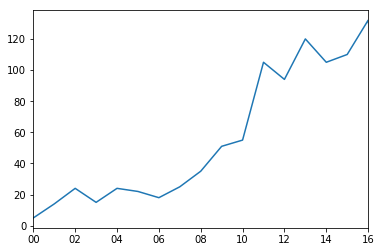

In [105]:
# examines when users first joined
entry_year = df_profile.loc[df_profile.join_year != 'NA', 'join_year']
entry = entry_year.value_counts().sort_index()
entry.plot()

plt.xlim([int(np.min(entry_year)),16])
plt.show()

Note the dip in 2002 and 2012 that coincides with the Great Fanfiction Purge of 2002 and 2012!

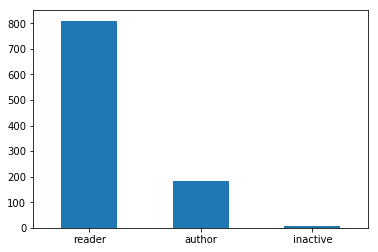

In [4]:
# examines status of users
status = df_profile['status'].value_counts()
status.plot.bar()
plt.xticks(rotation=0)

plt.show()

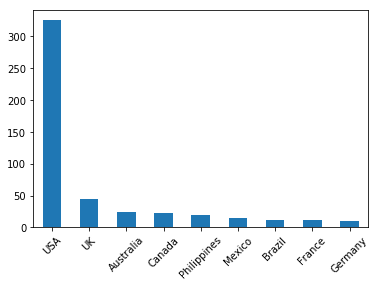

In [5]:
# examines distribution of top 10 countries
country = df_profile['country'].value_counts()
country[1:10].plot.bar()
plt.xticks(rotation=45)

plt.show()

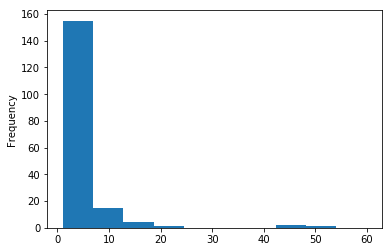

In [6]:
# examines distribution of stories written
st = df_profile.loc[df_profile.status != 'inactive', 'st']
st.plot.hist(range = [1, 60])

plt.show()

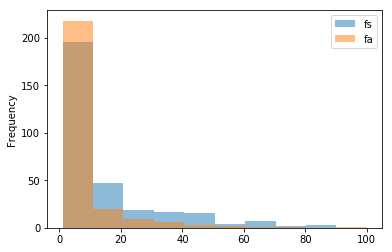

In [7]:
# examines distribution of favorited
fav = df_profile.loc[df_profile.status != 'inactive', ['fs', 'fa']]
fav.plot.hist(alpha = 0.5, range = [1, 100])

plt.show()

# Regression Analysis

In this section, we will try to predict the number of stories an (active) user would write based off the number of years have they been on the site, the number of authors/stories they have favorited, and whether or not they are in a community.

In [32]:
# creates copy of only active users
df_active = df_profile.loc[df_profile.status != 'inactive', ].copy()

# creates age variable
df_active['age'] = 17 - pd.to_numeric(df_active['join_year'])
df_active.loc[df_active.age < 0, 'age'] = df_active.loc[df_active.age < 0, 'age'] + 100
df_active = df_active[['st', 'fa', 'fs', 'cc', 'age']]

# turns cc into binary
df_active.loc[df_active['cc'] > 0, 'cc'] = 1

## Multicollinearity

In [33]:
# displays correlation matrix
df_active.corr()

,st,fa,fs,cc,age
st,1.000000,0.089321,0.142494,0.052937,0.170821
fa,0.089321,1.000000,0.706184,0.017645,0.007866
fs,0.142494,0.706184,1.000000,0.118110,0.011833
cc,0.052937,0.017645,0.118110,1.000000,0.113621
age,0.170821,0.007866,0.011833,0.113621,1.000000


In [34]:
# creates design_matrix 
X = df_active
X['intercept'] = 1

# displays variance inflation factor
vif_results = pd.DataFrame()
vif_results['VIF Factor'] = [vif(X.values, i) for i in range(X.shape[1])]
vif_results['features'] = X.columns
vif_results

,VIF Factor,features
0,1.051990,st
1,2.013037,fa
2,2.064973,fs
3,1.036716,cc
4,1.042636,age
5,2.824849,intercept


Results indicate there is some correlation between two of the independent variables: 'fa' and 'fs', implying one of them may not be necessary in the model.

## Nonlinearity

We know from earlier distributions that some of the variables are heavily right-skewed. We created some scatter plots to confirm that the assumption of linearity holds.

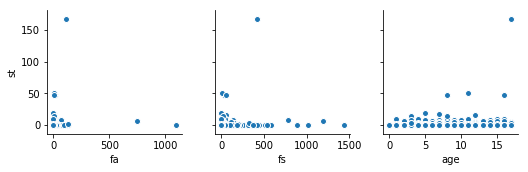

In [35]:
sns.pairplot(data=df_active, y_vars=['st'], x_vars=['fa', 'fs', 'age'])

plt.show()

The data is clustered around the zeros. Let's try a log transformation.

In [36]:
# takes log transformation
df_active['st'] = np.log(df_active['st']+1)
df_active['fa'] = np.log(df_active['fa']+1)
df_active['fs'] = np.log(df_active['fs']+1)

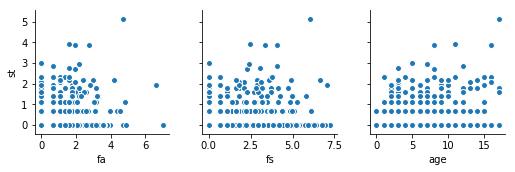

In [37]:
sns.pairplot(data=df_active, y_vars=['st'], x_vars=['fa', 'fs', 'age'])

plt.show()

## Regression Model

In [47]:
# runs OLS regression
formula = 'st ~ fa + fs + cc + age'
reg = smf.ols(data=df_active, formula=formula).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                     st   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     61.31
Date:                Thu, 03 Aug 2017   Prob (F-statistic):           2.70e-46
Time:                        18:53:22   Log-Likelihood:                -757.62
No. Observations:                 992   AIC:                             1525.
Df Residuals:                     987   BIC:                             1550.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0338      0.029     -1.171      0.2

The log transformations helped increase the fit from and R-squared of ~0.05 to ~0.20.

From these results, we can see that:

* A 1% change in number of authors favorited is associated with a ~15% change in the number of stories written.
* A 1% change in number of stories favorited is associated with a ~4% change in the number of stories written.
* Being in a community is associated with a ~0.7 increase in the number of stories written.
* One more year on the site is associated with a ~3% change in the number of stories written.

We noted earlier that 'fa' and 'fs' had a correlation of ~0.7. As such, we reran the regression without 'fa' first, then again without 'fs'. The model without 'fs' yielded a better fit (R-squared), as well as AIC and BIC.

In [48]:
# runs OLS regression
formula = 'st ~ fa + cc + age'
reg = smf.ols(data=df_active, formula=formula).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                     st   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.192
Method:                 Least Squares   F-statistic:                     79.67
Date:                Thu, 03 Aug 2017   Prob (F-statistic):           3.69e-46
Time:                        18:53:27   Log-Likelihood:                -760.24
No. Observations:                 992   AIC:                             1528.
Df Residuals:                     988   BIC:                             1548.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0169      0.028     -0.605      0.5

Without 'fs', we lost some information but not much:

* A 1% change in number of authors favorited is associated with a ~20% change in the number of stories written.
* Being in a community is associated with a ~0.7 increase in the number of stories written.
* One more year on the site is associated with a ~3% change in the number of stories written.

All these results seem to confirm a basic intuition that the more active an user reads (as measured by favoriting authors and stories), the likely it is that user will write more stories. Being longer on the site and being part of a community is also correlated to publications.

To get a sense of the actual magnitude of these effects, let's attempt some plots:

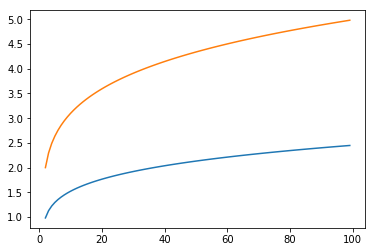

In [99]:
def graph(formula, x_range):  
    y = np.array(x_range)
    x = formula(y)
    plt.plot(y,x)  

graph(lambda x : (np.exp(reg.params[0]+reg.params[1]*(np.log(x-1)))), 
      range(2,100,1))
graph(lambda x : (np.exp(reg.params[0]+reg.params[1]*(np.log(x-1))+reg.params[2])), 
      range(2,100,1))

plt.show() 

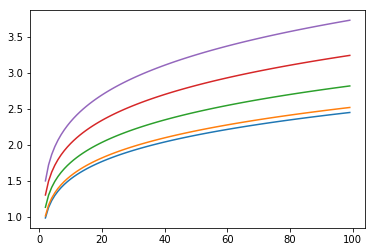

In [98]:
ages = [0, 1, 5, 10, 15]
for age in ages:
    graph(lambda x : (np.exp(reg.params[0]+reg.params[1]*(np.log(x-1))+reg.params[3]*age)), 
          range(2,100,1))

plt.show() 